In [ ]:
from keras.datasets import cifar10

In [1]:
import numpy as np
import os
import sys
from six.moves import cPickle

In [2]:
#libary from keras to init cnn
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.backend import common


Using TensorFlow backend.


In [3]:
import tensorflow as tf

In [ ]:
#you can dowload the dataset cifar10 by using below code
# (x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [4]:
_IMAGE_DATA_FORMAT = 'channels_last'

In [5]:
#https://www.cs.toronto.edu/~kriz/cifar.html
#load data from folder, join 6 path data to 1
#https://github.com/keras-team/keras/blob/c60f1e19dceacf77749a6215b1fc77f758f46327/keras/datasets/cifar.py
def load_batch(fpath, label_key='labels'):
    with open(fpath, 'rb') as f:
        if sys.version_info < (3,):
            d = cPickle.load(f)
        else:
            d = cPickle.load(f, encoding='bytes')
            # decode utf8
            d_decoded = {}
            for k, v in d.items():
                d_decoded[k.decode('utf8')] = v
            d = d_decoded
    data = d['data']
    labels = d[label_key]

    data = data.reshape(data.shape[0], 3, 32, 32)
    return data, labels

#https://github.com/keras-team/keras/blob/c60f1e19dceacf77749a6215b1fc77f758f46327/keras/backend/common.py
def image_data_format():
    """Returns the default image data format convention ('channels_first' or 'channels_last').
    # Returns
        A string, either `'channels_first'` or `'channels_last'`
    # Example
    ```python
        >>> keras.backend.image_data_format()
        'channels_first'
    ```
    """
    return _IMAGE_DATA_FORMAT
#https://github.com/keras-team/keras/blob/c60f1e19dceacf77749a6215b1fc77f758f46327/keras/datasets/cifar10.py
def loaddata():
    path = 'cifar10'
    num_train_samples = 50000

    x_train = np.empty((num_train_samples, 3, 32, 32), dtype='uint8')
    y_train = np.empty((num_train_samples,), dtype='uint8')

    for i in range(1, 6):
        fpath = os.path.join(path, 'data_batch_' + str(i))
        (x_train[(i - 1) * 10000: i * 10000, :, :, :],
         y_train[(i - 1) * 10000: i * 10000]) = load_batch(fpath)

    fpath = os.path.join(path, 'test_batch')
    x_test, y_test = load_batch(fpath)

    y_train = np.reshape(y_train, (len(y_train), 1))
    y_test = np.reshape(y_test, (len(y_test), 1))

    if image_data_format() == 'channels_last':
        x_train = x_train.transpose(0, 2, 3, 1)
        x_test = x_test.transpose(0, 2, 3, 1)

    return (x_train, y_train), (x_test, y_test)



In [6]:
(x_train, y_train), (x_test, y_test) = loaddata()

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import PIL.Image
from scipy.misc import toimage

In [8]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

In [9]:
#display the sample of train
############################
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [10]:
print(x_train.shape[1:])

(32, 32, 3)


In [11]:
#init variable
batch_size = 32
num_classes = 10
epochs = 5

In [12]:
# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [11]:
y_train.shape

(50000, 10)

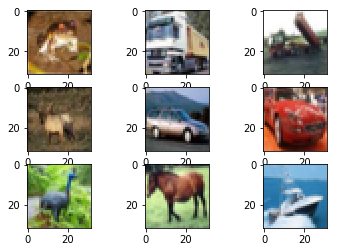

In [13]:
#plot image for each label
for i in range(0, 9):
    plt.subplot(330 + 1 + i)
    plt.imshow(PIL.Image.fromarray(x_train[i]))
# show the plot
plt.show()

In [14]:
# normalize inputs from 0-255 to 0.0-1.0
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train = x_train / 255.0
x_test = x_test / 255.0

In [19]:
#create the model
model = Sequential()
#first layer 
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
#model.add(BatchNormalization())
#2nd layer
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
# model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
#3rd layrer
model.add(Conv2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))
# model.add(BatchNormalization())
#
model.add(Conv2D(256, (3, 3)))
model.add(Activation('relu'))
# model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
#fully-connected layer 1
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
#output layer2
model.add(Dense(num_classes))
model.add(Activation('softmax'))

In [26]:
#optimize using Adam with learning rate = 0.001
opt = keras.optimizers.Adam(lr=0.001, decay=1e-6)

# Let's train the model using Adam
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [21]:
#train model
with tf.device('/gpu:0'):
    history = model.fit(x_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        validation_data=(x_test, y_test),
                        shuffle=True)
scores = model.evaluate(x_test, y_test, batch_size=128, verbose=1)
print('\nTest result: %.3f loss: %.3f' % (scores[1]*100,scores[0]))

Train on 50000 samples, validate on 10000 samples
Epoch 1/5
50000/50000 [==============================] - 209s 4ms/step - loss: 1.4605 - acc: 0.4664 - val_loss: 1.0476 - val_acc: 0.6252
Epoch 2/5
50000/50000 [==============================] - 209s 4ms/step - loss: 1.0543 - acc: 0.6281 - val_loss: 0.8970 - val_acc: 0.6841
Epoch 3/5
50000/50000 [==============================] - 211s 4ms/step - loss: 0.8984 - acc: 0.6845 - val_loss: 0.8280 - val_acc: 0.7118
Epoch 4/5
50000/50000 [==============================] - 216s 4ms/step - loss: 0.7982 - acc: 0.7195 - val_loss: 0.7323 - val_acc: 0.7486
Epoch 5/5
10000/10000 [==============================] - 7s 715us/step

Test result: 75.880 loss: 0.694


In [22]:
model.save_weights('cifar10_normal_rms_ep75.h5')

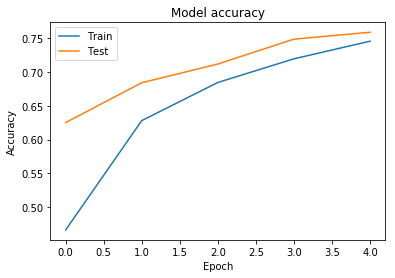

In [23]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


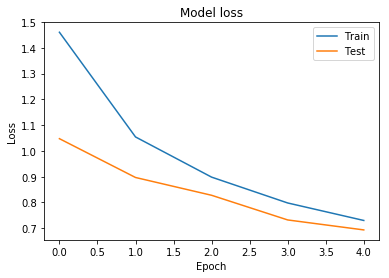

In [25]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()